# AutoEncoder (AE)
---
- 회귀와 분류모델은 지도학습으로, 신경망 모델은 처음에 이 지도학습을 위해 개발됨. 
- 그러나 신경망 모델의 학습 알고리즘의 특성상 다른 방식으로도(비지도학습) 개발되기 시작함. 
- 데이터를 생성하는 딥러닝 모델인 Generative Adversarial Networks(GAN)도 그 중 하나임. 
- AutoEncoder는 대표적인 비지도학습 신경망 모델로, Input과 Output을 아래 그림과 같이 똑같이 설정함. 

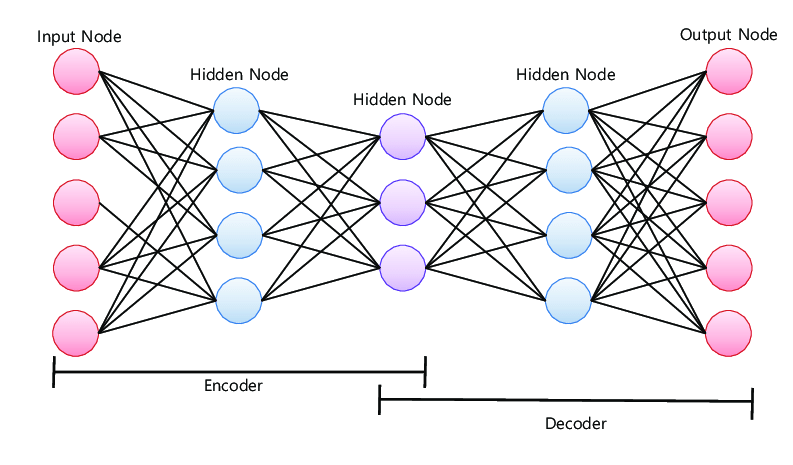

- Hidden Layer의 앞부분을 인코더, 뒷부분을 디코더라고 함. 
- 즉, Input Data에 대해 Hidden Layer로 인코딩(압축)한 후 다시 원래 Input Data로 디코딩(복원)하는 개념이라 볼 수 있음. 
- AE를 확용하면 Input Data를 Latent Space(잠재 공간)에 압축시켜 이 값을 새로운 Feature로 사용할 수 있음. 
- Feature Extraction의 일종으로 새로운 Feature를 사용했을 때 기존의 Feature를 사용할 때보다 성능이 좋고(항상은 아니라고 함), Dimension을 줄일 수 있다는 장점이 있음. 
- AE의 학습 과정은 데이터를 원래의 데이터로 잘 복원하도록 학습시키는 것으로 이해할 수 있음. 
- 자기자신을 잘 복원할 수 있는 모델이라면 복원하는 과정 중에 있는 압축했을 때의 Feature는 Feature로서의 의미가 있을 것이라 이해할 수 있다고 함.

## FashionMNIST를 활용해 AutoEncoder 설계하기
---
- 이번에는 특정 값으로 예측하거나 특정 클래스로 분류하는 것이 아니라 원본 데이터를 생성하는 AutoEncoder를 실습해보자. 
- 흑백 이미지가 10개의 옷 종류로 분류되어 있는 FashionMNIST 데이터를 이용해 기본적인 MLP 구조의 AutoEncoder를 설계해보자. 
- AutoEncoder 모델을 설계하는 순서는 다음과 같음. 


1. 모듈 임포트
2. 딥러닝 모델을 설계할 때 활용하는 장비 확인하기
3. FashionMNIST 데이터 다운로드하기 (train / test set 분리하기)
4. 데이터 확인하기 (1)
5. 데이터 확인하기 (2)
6. AutoEncoder(AE) 모델 설계하기
7. Optimizer, Objective Function 설정하기
8. AE 모델 학습을 진행하면서 학습 데이터에 대한 모델의 성능을 확인하는 함수 정의하기
9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의하기
10. AutoEncoder 학습을 실행하면서 test set의 Reconstruction Error 확인하기  

In [1]:
'''1. Module Import'''

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
'''2. 딥러닝 모델을 설계할 때 활용하는 장비 확인'''

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)
print(torch.cuda.get_device_name(0))

Using PyTorch version:  1.11.0 Device:  cuda
NVIDIA GeForce RTX 3080 Ti


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
'''3. FashionMNIST 데이터 다운로드 (train / test set 분리하기)'''

train_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                                     train=True,
                                     download=True,
                                     transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                                    train=False,
                                    transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

In [5]:
'''4. 데이터 확인하기 (1)'''

for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


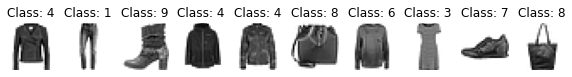

In [6]:
'''5. 데이터 확인하기 (2)'''

pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
'''6. AutoEncoder(AE) 모델 설계하기'''

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28*28, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(nn.Linear(32, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 28*28),)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [8]:
'''7. Optimizer, Objective Function 설정하기'''

model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


- AE 모델의 Output 값과 계산될 Label 값은 이미지 데이터 그 자체임. 
- AE 모델의 Output 값은 Input으로 이용된 이미지 데이터와 복원된 이미지 데이터 값 간의 MeanSquaredError를 이용해 계산하기 위해 criterion은 nn.MSELoss()로 설정함. 

In [9]:
'''8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def train(model, train_loader, optimizer, log_interval):
    model.train()
    
    # 레이블 데이터를 활용해 학습하는 것이 아니라 입력 데이터를 타깃으로 학습하기 때문에 레이블 데이터를 이용할 필요가 없음. 
    # 따라서 기존에 이용된 Label 값을 _로 설정해 생략함. 
    for batch_idx, (image, _) in enumerate(train_loader):
        
        # Mini-Batch 내에 있는 이미지 데이터를 기존에 정의한 장비에 할당
        # 정의한 AE의 Input은 28 * 28 크기의 1차원 레이어이므로 2차원 데이터를 1차원 데이터로 재구성해 할당해야 함. 
        image = image.view(-1, 28*28).to(DEVICE)
        target = image.view(-1, 28*28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100. * batch_idx / len(train_loader),
            loss.item()))

In [10]:
'''9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(DEVICE)
            target = image.view(-1, 28*28).to(DEVICE)
            encoded, decoded = model(image)
            
            # AE 모델을 통해 생성된 이미지와 실제 이미지간 MSE 값을 계산해 test_loss 값 업데이트
            test_loss += criterion(decoded, image).item()
            
            # 실제 이미지로 할당된 이미지를 'real.image' 리스트에 추가
            real_image.append(image.to("cpu"))
            
            # AE 모델을 통해 생성된 이미지를 'gen.image' 리스트에 추가
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= len(test_loader.dataset)
    
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.197297
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.032973
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.021527
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.022507
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.022798
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.020514
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.018360
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.016490
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.016198
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.018187

[EPCOH: 1], 	Test Loss: 0.0005


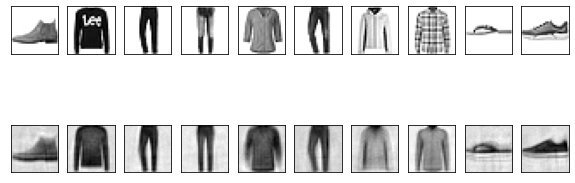

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.015200
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.016369
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.015240
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.016572
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.013394
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.015799
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.013193
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.011951
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.015070
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.018657

[EPCOH: 2], 	Test Loss: 0.0004


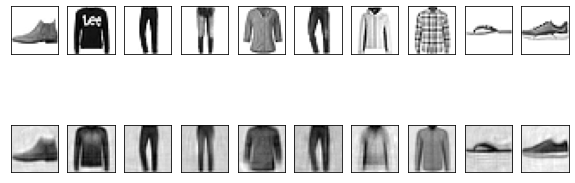

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.013250
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.015228
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.012066
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.012927
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.010777
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.013591
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.012444
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.014239
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.011359
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.011413

[EPCOH: 3], 	Test Loss: 0.0004


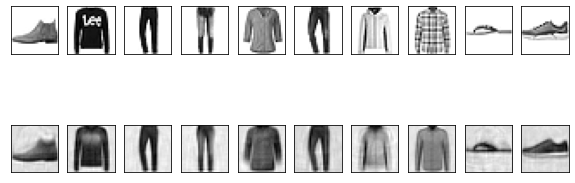

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.011964
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.012393
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.010834
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.009852
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.010125
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.012444
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.010419
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.013183
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.012464
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.009449

[EPCOH: 4], 	Test Loss: 0.0004


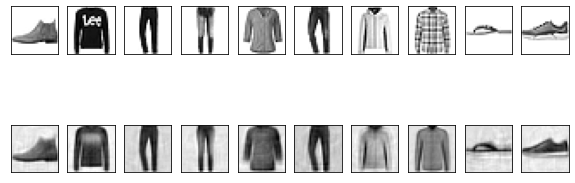

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.010390
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.009600
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.008677
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.011647
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.012497
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.009293
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.010700
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.011219
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.011091
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.007881

[EPCOH: 5], 	Test Loss: 0.0003


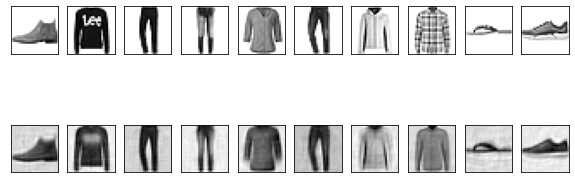

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.009226
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.010300
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.009542
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.011534
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.010577
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.012116
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.010820
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.009725
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.010061
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.009089

[EPCOH: 6], 	Test Loss: 0.0003


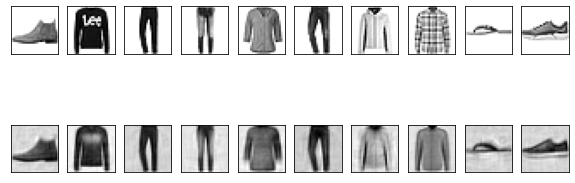

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.009638
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.009478
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.012519
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.008224
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.010480
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.009896
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.009621
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.008009
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.009897
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.014253

[EPCOH: 7], 	Test Loss: 0.0003


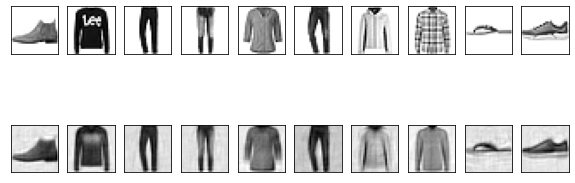

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.012086
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.009819
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.008822
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.009504
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.008276
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.009299
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.009913
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.010386
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.008302
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.008147

[EPCOH: 8], 	Test Loss: 0.0003


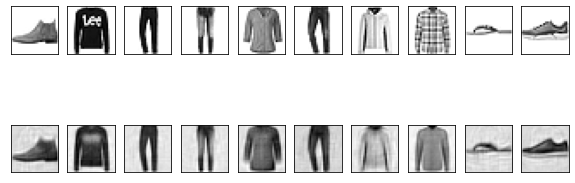

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.008737
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.009242
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.008664
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.009496
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.011214
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.008642
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.009309
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.007790
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.011235
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.009531

[EPCOH: 9], 	Test Loss: 0.0003


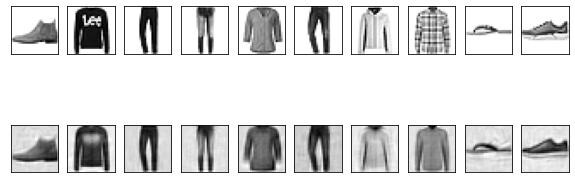

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.010541
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.010723
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.008206
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.010106
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.009497
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.009739
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.008530
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.008794
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.009053
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.010093

[EPCOH: 10], 	Test Loss: 0.0003


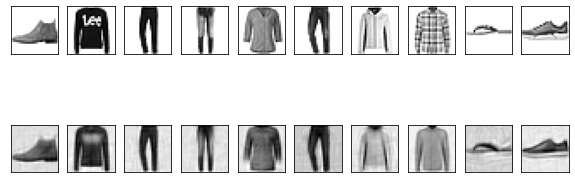

In [11]:
'''10. AutoEncoder 학습을 실행하며 test set의 Reconstruction Error 확인하기'''

for Epoch in range(1, EPOCHS+1):
    
    # 정의한 train 함수 실행
    train(model, train_loader, optimizer, log_interval=200)
    
    # 각 Epoch별 출력되는 Loss 값과 실제 이미지, 생성된 이미지를 저장한 real_image, gen_image 리스트 생성
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPCOH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize=(10, 4))
    
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap="gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap="gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
        
    plt.show()

## Reference
---
- 파이썬 딥러닝 파이토치 - 이경택, 방성수, 안상준